In [ ]:
from Params.path_params import Data_path
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
from numba import jit

In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
jdata_path = "{0}/JData".format(Data_path)
trade_train_file = "{0}/t_trade.csv".format(jdata_path)
trade_test_file = "{0}/t_trade_test.csv".format(jdata_path)
login_train_file = "{0}/t_login.csv".format(jdata_path)
login_test_file = "{0}/t_login_test.csv".format(jdata_path)

In [4]:
df_trade = pd.read_csv(trade_train_file)

In [5]:
df_login = pd.read_csv(login_train_file)

In [6]:
df_trade['time'] =pd.to_datetime(df_trade['time'], utc=True)
df_login[['is_scan','is_sec']] = df_login[['is_scan','is_sec']].astype(int)
df_login = df_login.drop('timestamp', axis=1)
df_login['time'] = pd.to_datetime(df_login['time'], utc=True)
df_login = df_login.rename(columns={'time':'login_time'})

In [7]:
df_trade.head(5)

,rowkey,time,id,is_risk
0,3,2015-01-01 00:00:41,27863,0
1,6,2015-01-01 00:00:46,115201,0
2,13,2015-01-01 00:01:02,143711,0
3,32,2015-01-01 00:03:00,172699,0
4,43,2015-01-01 00:03:52,53265,0


In [8]:
df = df_trade.merge(df_login, on='id', how='left')

In [9]:
df.shape

(7882778, 15)

In [10]:
df = df.loc[df.login_time < df.time]

In [11]:
df.shape

(4040462, 15)

In [12]:
df = df.sort_values(['login_time', 'time'], ascending=[True, True])

In [13]:
df_login_trade = df.groupby('rowkey').last().reset_index()
df = df_login.merge(df_login_trade[['login_time', 'is_risk', 'id', 'rowkey', 'time']], on=['id', 'login_time'],
                    how='left')

In [14]:
df['time_delta'] = df.loc[df.time.notnull()].apply(lambda x: (x['time'] - x['login_time']), axis=1)

In [15]:
df.loc[df.time.notnull()].shape

(123602, 16)

In [16]:
df_login.shape

(595645, 12)

In [17]:
df.shape

(651915, 16)

In [18]:
def get_login_features(df, col='id', time_range='7D', feature_cols=[]):
    """
    this function usde to get login features
    :param df:
    :param col:
    :param feature_cols:
    :param time_range:
    :return:
    """
    df_g = df.groupby(col)[feature_cols].rolling(time_range).apply(lambda x: np.unique(x).shape[0])
    df_g = df_g.reset_index(0).sort_index().drop(col, axis=1)
    rename_cols = {x: "{0}_{1}_num".format(col, x) for x in feature_cols}
    df_g = df_g.rename(columns=rename_cols)
    return df_g, rename_cols
    # new_cols = df_g.columns.difference(['id', 'login_time'])
    # df_feature_chk = get_num_ocr_check(df=df_g, cols=new_cols)
    # df_new = pd.concat([df_g, df_feature_chk], axis=1)
    # new_feature_cols = df_new.columns
    # return df_new, new_feature_cols


def get_not_net_features(df, col='id', time_range='7D', feature_cols=[]):
    """
    获取非网络特征
    :param df:
    :param time_range:
    :param feature_cols:
    :return:
    """

    def get_max_count(x):
        (values, counts) = np.unique(x, return_counts=True)
        ind = np.argmax(counts)
        return values[ind]

    df[feature_cols] = df[feature_cols].astype(int)
    df_g = df.groupby(col)[feature_cols].rolling(time_range).apply(lambda x: get_max_count(x))
    df_g = df_g.reset_index(0).sort_index().drop(col, axis=1)
    rename_cols = {x: "{0}_ocred_{1}".format(x, time_range) for x in feature_cols}
    df_g = df_g.rename(columns=rename_cols)
    df_g = pd.concat([df[feature_cols], df_g], axis=1)
    for col1 in feature_cols:
        col_u = rename_cols[col1]
        df_g[col_u] = df_g.apply(lambda x: 1 if x[col_u] == x[col1] else 0, axis=1)
    df_g = df_g[rename_cols.values()]
    return df_g, rename_cols


def get_num_ocr_check(df, cols, threshold=1):
    """
    check if any col unique login times > threshold
    :param df:
    :param cols:
    :param threshold:
    :return:
    """

    @jit
    def check_ocr(x):
        if x > threshold:
            return 1
        else:
            return 0

    df = df[cols].applymap(lambda x: check_ocr(x))
    _cols = df.columns
    rename_cols = {x: "{0}_chk_ocr_gt_{1}".format(x, threshold) for x in _cols}
    df = df.rename(columns=rename_cols)
    return df


def get_risk_history(df, col):
    """
    get user ever do risk trade
    :param df:
    :param col:
    :return:
    """
    col_ = "{0}_ocred".format(col)
    # first_time = df.loc[df[col] >= 1].index.min()
    # df1 = df.truncate(before=first_time)
    # df2 = df.truncate(after=first_time)
    # df1[col_] = 0
    # df2[col_] = 1
    # df_new = pd.concat([df1, df2], axis=0)
    # df_new = df_new[[col_]]
    df_new = df.groupby('id')[[col]].expanding().apply(lambda x: 1 if x.any() == 1 else 0)
    df_new = df_new.rename(columns={col: col_})
    df_new = df_new.reset_index(0).sort_index().drop('id', axis=1).fillna(0)
    return df_new, col_

In [19]:
df = df.set_index('login_time')
df = df.sort_index()

In [20]:
def check_mid_night(x):
    if x:
        hour = x.hour
        if 0 <= hour <= 3:
            return 1
        else:
            return 0
    else:
        return 0


In [21]:
df.head()

,log_id,timelong,device,log_from,ip,city,result,type,id,is_scan,is_sec,is_risk,rowkey,time,time_delta
login_time,,,,,,,,,,,,,,,
2015-01-01 00:00:15,7.775528e+15,0.0,421584,2,1327200,364,1,1,113124,0,0,NaN,NaN,NaT,NaT
2015-01-01 00:00:29,5.707914e+14,3000.0,764868,1,1482812,102,1,3,121137,0,0,NaN,NaN,NaT,NaT
2015-01-01 00:00:54,2.350545e+16,2000.0,210427,2,1182527,103,1,3,9219,0,0,NaN,NaN,NaT,NaT
2015-01-01 00:00:55,2.161775e+16,12911.0,44973,1,1470338,485,1,3,100340,0,0,NaN,NaN,NaT,NaT
2015-01-01 00:00:58,7.393815e+15,12594.0,529364,1,869735,23,1,1,59555,0,0,NaN,NaN,NaT,NaT


In [22]:
df['trade_time_check'] = df['time'].apply(lambda x: check_mid_night(x))

In [23]:
df_r = df.groupby('id')['log_id'].rolling('1D').apply(lambda x: np.unique(x).shape[0])
df_r = df_r.reset_index(0).sort_index()
df_r = df_r.rename(columns={'log_id': 'one_day_login'})

In [24]:
df_r['one_day_login'] = df_r['one_day_login']. \
    apply(lambda x: 1 if x > 1 else 0)
df_r = df_r.drop('id', axis=1)

In [25]:
df_r.head()

,one_day_login
login_time,
2015-01-01 00:00:15,0
2015-01-01 00:00:29,0
2015-01-01 00:00:54,0
2015-01-01 00:00:55,0
2015-01-01 00:00:58,0


In [26]:
org_used_cols = ['is_scan', 'is_sec', 'timelong', 'is_risk', 'time_delta', 'trade_time_check', 'rowkey']

In [27]:

# features.append('one_day_login')
features = []
features.extend(org_used_cols)
org_not_used_cols = df.columns.difference(org_used_cols)
print(org_not_used_cols)

Index([u'city', u'device', u'id', u'ip', u'log_from', u'log_id', u'result',
       u'time', u'type'],
      dtype='object')


In [28]:
df_risk_h, risk_h_col = get_risk_history(df, col='is_risk')
print('risk features done')

risk features done


In [29]:
df_risk_h.shape

(651915, 1)

In [30]:
features.append(risk_h_col)
# 网络特征
login_features = ['city', 'type', 'result', 'log_from', 'device', 'ip']
df_login_features, login_cols = get_login_features(df=df, col='id', feature_cols=login_features)
features.extend(login_cols.values())
print('network features done')
# 非网络特征
device_features = ['city', 'type', 'result', 'log_from', 'device', 'ip']
df_dev_features, dev_cols = get_not_net_features(df=df, feature_cols=device_features)
features.extend(dev_cols.values())
print('not network features done')

network features done
not network features done


In [31]:
df_dev_features.shape

(651915, 6)

In [32]:
print org_used_cols

['is_scan', 'is_sec', 'timelong', 'is_risk', 'time_delta', 'trade_time_check', 'rowkey']


In [33]:
df_r.shape

(651915, 1)

In [34]:
df_login_features.columns

Index([u'id_city_num', u'id_type_num', u'id_result_num', u'id_log_from_num',
       u'id_device_num', u'id_ip_num'],
      dtype='object')

In [35]:
df_dev_features.columns

Index([u'city_ocred_7D', u'ip_ocred_7D', u'log_from_ocred_7D',
       u'result_ocred_7D', u'device_ocred_7D', u'type_ocred_7D'],
      dtype='object')

In [36]:
df_new = pd.concat([df[org_used_cols], df_r, df_login_features, df_dev_features, df_risk_h], axis=1)
print('concat done')

concat done


In [37]:
df_new.shape

(651915, 21)

In [44]:
df_new.columns

Index([u'is_scan', u'is_sec', u'timelong', u'is_risk', u'time_delta',
       u'trade_time_check', u'rowkey', u'one_day_login', u'id_city_num',
       u'id_type_num', u'id_result_num', u'id_log_from_num', u'id_device_num',
       u'id_ip_num', u'city_ocred_7D', u'ip_ocred_7D', u'log_from_ocred_7D',
       u'result_ocred_7D', u'device_ocred_7D', u'type_ocred_7D',
       u'is_risk_ocred'],
      dtype='object')

In [43]:
df_new.reset_index().sort_values(by='login_time').groupby('rowkey').last().reset_index(drop=True).set_index('login_time')

,is_scan,is_sec,timelong,is_risk,time_delta,trade_time_check,one_day_login,id_city_num,id_type_num,id_result_num,id_log_from_num,id_device_num,id_ip_num,city_ocred_7D,ip_ocred_7D,log_from_ocred_7D,result_ocred_7D,device_ocred_7D,type_ocred_7D,is_risk_ocred
login_time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:20:01,0,0,1000.0,1.0,0 days 00:05:03,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,1,1,1.0
2015-01-01 00:20:01,0,0,1000.0,0.0,0 days 00:06:27,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,0,1,1.0
2015-01-01 00:20:01,0,0,1000.0,1.0,0 days 00:07:23,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,1,1,1.0
2015-01-01 00:26:18,0,0,3000.0,0.0,0 days 00:21:53,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,0.0
2015-01-01 00:20:34,0,0,2000.0,0.0,0 days 00:30:07,1,1,1.0,3.0,2.0,1.0,1.0,1.0,1,1,1,0,1,0,1.0
2015-01-01 01:02:57,0,0,25153.0,0.0,0 days 00:02:50,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,0.0
2015-01-01 00:56:05,0,0,13687.0,0.0,0 days 00:09:50,1,1,1.0,1.0,2.0,1.0,1.0,1.0,1,1,1,1,1,1,1.0
2015-01-01 01:51:18,0,0,3000.0,0.0,0 days 00:15:26,1,1,1.0,1.0,1.0,2.0,2.0,1.0,1,1,1,1,1,1,1.0
2015-01-01 02:59:24,0,0,9000.0,1.0,0 days 00:02:37,1,1,3.0,1.0,1.0,2.0,2.0,3.0,1,1,1,1,1,1,1.0


In [38]:
# df_new = df_new.groupby('rowkey').last().reset_index(0).sort_index()

In [42]:
df_new.head()

,rowkey,is_scan,is_sec,timelong,is_risk,time_delta,trade_time_check,one_day_login,id_city_num,id_type_num,...,id_log_from_num,id_device_num,id_ip_num,city_ocred_7D,ip_ocred_7D,log_from_ocred_7D,result_ocred_7D,device_ocred_7D,type_ocred_7D,is_risk_ocred
0,189.0,0,0,1000.0,1.0,00:05:03,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,1,1,1.0
1,205.0,0,0,1000.0,0.0,00:06:27,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,0,1,1.0
2,211.0,0,0,1000.0,1.0,00:07:23,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,1,1,1.0
3,282.0,0,0,3000.0,0.0,00:21:53,1,0,1.0,1.0,...,1.0,1.0,1.0,1,1,1,1,1,1,0.0
4,293.0,0,0,2000.0,0.0,00:30:07,1,1,1.0,3.0,...,1.0,1.0,1.0,1,1,1,0,1,0,1.0


In [39]:
df_new.shape

(121200, 21)

In [40]:
# df_z = df_new[features]
# df_z = df_z.loc[df_z['time'].notnull()].drop('time', axis=1)
df_z = df_new.rename(columns={'is_risk': 'label'})
print(df_z.columns[df_z.isnull().any()])
print("all features are: {0}".format(df_z.columns.tolist()))

Index([], dtype='object')
all features are: ['rowkey', 'is_scan', 'is_sec', 'timelong', 'label', 'time_delta', 'trade_time_check', 'one_day_login', 'id_city_num', 'id_type_num', 'id_result_num', 'id_log_from_num', 'id_device_num', 'id_ip_num', 'city_ocred_7D', 'ip_ocred_7D', 'log_from_ocred_7D', 'result_ocred_7D', 'device_ocred_7D', 'type_ocred_7D', 'is_risk_ocred']


In [41]:
df_z.head()

,rowkey,is_scan,is_sec,timelong,label,time_delta,trade_time_check,one_day_login,id_city_num,id_type_num,...,id_log_from_num,id_device_num,id_ip_num,city_ocred_7D,ip_ocred_7D,log_from_ocred_7D,result_ocred_7D,device_ocred_7D,type_ocred_7D,is_risk_ocred
0,189.0,0,0,1000.0,1.0,00:05:03,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,1,1,1.0
1,205.0,0,0,1000.0,0.0,00:06:27,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,0,1,1.0
2,211.0,0,0,1000.0,1.0,00:07:23,1,1,1.0,1.0,...,1.0,2.0,1.0,1,1,1,1,1,1,1.0
3,282.0,0,0,3000.0,0.0,00:21:53,1,0,1.0,1.0,...,1.0,1.0,1.0,1,1,1,1,1,1,0.0
4,293.0,0,0,2000.0,0.0,00:30:07,1,1,1.0,3.0,...,1.0,1.0,1.0,1,1,1,0,1,0,1.0


In [60]:
df_z.shape

(121200, 21)

In [61]:
df_chk = pd.read_csv('../script/debug.csv')

In [62]:
df_chk.head()

,is_scan,is_sec,timelong,label,time_delta,trade_time_check,one_day_login,id_city_num,id_type_num,id_result_num,id_log_from_num,id_device_num,id_ip_num,city_ocred_7D,ip_ocred_7D,log_from_ocred_7D,result_ocred_7D,device_ocred_7D,type_ocred_7D,is_risk_ocred
0,0,0,1000.0,1.0,0 days 00:05:03.000000000,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,1,1,1.0
1,0,0,1000.0,0.0,0 days 00:06:27.000000000,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,0,1,1.0
2,0,0,1000.0,1.0,0 days 00:07:23.000000000,1,1,1.0,1.0,1.0,1.0,2.0,1.0,1,1,1,1,1,1,1.0
3,0,0,3000.0,0.0,0 days 00:21:53.000000000,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1,0.0
4,0,0,2000.0,0.0,0 days 00:30:07.000000000,1,1,1.0,3.0,2.0,1.0,1.0,1.0,1,1,1,0,1,0,1.0


In [47]:
df_chk.shape

(123602, 20)

In [51]:
# -*- coding: utf-8 -*-
# Project: local-spark
# Author: chaoxu create this file
# Time: 2018/2/1
# Company : Maxent
# Email: chao.xu@maxent-inc.com
from __future__ import print_function, division
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Pic.maxent_style import maxent_style


def df_nor():
    df1 = pd.DataFrame(np.random.randint(100, 200, 10), columns=[u'消费金额'],
                       index=range(10))
    df2 = pd.DataFrame(np.random.randint(140, 160, 20), columns=[u'消费金额'],
                       index=range(20))
    df = pd.concat([df1, df2], axis=0).reset_index(drop=True)
    return df


def df_anor():
    df = pd.DataFrame(np.random.randint(140, 160, 36), columns=[u'消费金额'],
                      index=range(36))
    return df.reset_index(drop=True)


@maxent_style
def fraud_consume(fname, dpi=600, palette=None):
    """
    生成欺诈展示图
    :return:
    """
    # df1 = pd.DataFrame(np.random.randint(100, 200, 100), columns=[u'消费金额'],
    #                    index=pd.date_range(start='20170101', periods=100, freq='D'))
    # df2 = pd.DataFrame(np.random.randint(150, 155, 50), columns=[u'消费金额'],
    #                    index=pd.date_range(start='20170411', periods=50, freq='D'))
    # df3 = pd.DataFrame(np.random.randint(100, 200, 100), columns=[u'消费金额'],
    #                    index=pd.date_range(start='20170531', periods=100, freq='D'))
    df1 = map(lambda x: df_nor(), range(5))
    df2 = map(lambda x: df_anor(), range(1))
    df3 = map(lambda x: df_nor(), range(6))
    df_list = df1+df2+df3
    df = pd.concat(df_list, axis=0)
    df = df.reset_index()
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    br_log = df.plot.line(ax=ax, logy=True)
    ax.set_title(u"异常消费行为")
    ax.set_ylabel(u"消费额度")
    ax.xaxis.set_ticks([])
    fig.subplots_adjust(bottom=0.2, top=0.95)
    fig.savefig(filename=fname, dpi=dpi, format='png')
    plt.show(block=False)



In [52]:
df1 = map(lambda x: df_nor(), range(5))
df2 = map(lambda x: df_anor(), range(1))
df3 = map(lambda x: df_nor(), range(6))
df_list = df1+df2+df3

In [53]:
df = pd.concat(df_list, axis=0)

In [54]:
df.head()

,消费金额
0,104
1,151
2,172
3,113
4,175


In [55]:
df = df.reset_index(drop=True
                )

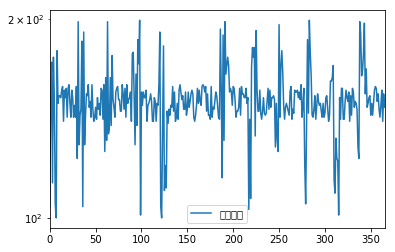

In [60]:
df.plot.line(logy=True)

In [76]:
df.iloc[-1].values[0]

147

In [72]:
df.iloc[-1, u'消费金额']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [63]:
df

,消费金额
0,104
1,1
2,172
3,113
4,175
5,151
6,105
7,100
8,179
9,149
